In [52]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
#from sklearn.neighbors import KNeighborsClassifier # testing if KNN is better


In [53]:
# load cleaned dataset
df = pd.read_csv("../data/processed/cleaned_rentals.csv")
print("Dataset loaded with shape:", df.shape)
df.head()

Dataset loaded with shape: (196, 49)


,rentfaster_id,city,province,address,latitude,longitude,price,beds,baths,sq_feet,...,availability_date_Negotiable,availability_date_No Vacancy,availability_date_November 24,availability_date_October 01,availability_date_October 04,availability_date_September 01,smoking_Non-Smoking,smoking_Smoke Free Building,cats_True,dogs_True
0,544095,Vancouver,British Columbia,1770 Pendrell Street,49.287460,-123.140530,3895.0,2,2.0,820.0,...,False,False,False,False,False,False,True,False,True,True
1,544095,Vancouver,British Columbia,1770 Pendrell Street,49.287460,-123.140530,2695.0,1,1.0,440.0,...,False,False,False,False,False,False,True,False,True,True
2,544095,Vancouver,British Columbia,1770 Pendrell Street,49.287460,-123.140530,4395.0,2,2.0,639.0,...,False,False,False,False,False,False,True,False,True,True
3,544095,Vancouver,British Columbia,1770 Pendrell Street,49.287460,-123.140530,3300.0,1,1.0,650.0,...,False,False,False,False,False,False,True,False,True,True
4,559642,Vancouver,British Columbia,1477 Continental Street,49.274461,-123.130948,2450.0,1,1.0,639.0,...,False,False,False,False,False,False,False,False,True,True


In [54]:
# Keep only the desired columns
cols_to_keep = [
    "sq_ft", "beds", "baths", "type_Townhouse", "furnishing_Negotiable","furnishing_Unfurnished",
     "type_Basement","type_Condo Unit","type_Main Floor", "latitude", "longitude", "price",
     "smoking_Non-Smoking","smoking_Smoke Free Building","cats_True","dogs_True"
     "lease_term_6 months","lease_term_Long Term","lease_term_Negotiable","lease_term_Short Term"
]
available_cols = [col for col in cols_to_keep if col in df.columns]
df = df[available_cols].dropna()
print("Dataset loaded with shape:", df.shape)
df.head()


Dataset loaded with shape: (196, 17)


,beds,baths,type_Townhouse,furnishing_Negotiable,furnishing_Unfurnished,type_Basement,type_Condo Unit,type_Main Floor,latitude,longitude,price,smoking_Non-Smoking,smoking_Smoke Free Building,cats_True,lease_term_Long Term,lease_term_Negotiable,lease_term_Short Term
0,2,2.0,False,False,True,False,False,False,49.287460,-123.140530,3895.0,True,False,True,True,False,False
1,1,1.0,False,False,True,False,False,False,49.287460,-123.140530,2695.0,True,False,True,True,False,False
2,2,2.0,False,False,True,False,False,False,49.287460,-123.140530,4395.0,True,False,True,True,False,False
3,1,1.0,False,False,True,False,False,False,49.287460,-123.140530,3300.0,True,False,True,True,False,False
4,1,1.0,False,False,False,False,False,False,49.274461,-123.130948,2450.0,False,False,True,True,False,False


In [55]:
#Step 2: Load the regression model 
regression_model = joblib.load("linear_regression_model.pkl")

In [56]:
#Step 3: Predict fair prices and label data 
X_reg = df.drop(columns=["price"])
y_actual = df["price"].values

predicted_price = regression_model.predict(X_reg)

price_ratio = y_actual / predicted_price
labels = []
for ratio in price_ratio:
    if ratio < 0.9:
        labels.append("underpriced")
    elif ratio > 1.1:
        labels.append("overpriced")
    else:
        labels.append("fair")

df["label"] = labels

In [57]:
#Step 4: Train Random Forest Classifier
X = X_reg.copy()
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
#clf = KNeighborsClassifier(n_neighbors=5)  # Using KNN for testing purposes
clf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Classification Report:

              precision    recall  f1-score   support

        fair       0.46      0.55      0.50        20
  overpriced       0.33      0.20      0.25         5
 underpriced       0.31      0.27      0.29        15

    accuracy                           0.40        40
   macro avg       0.37      0.34      0.35        40
weighted avg       0.39      0.40      0.39        40

Confusion Matrix:



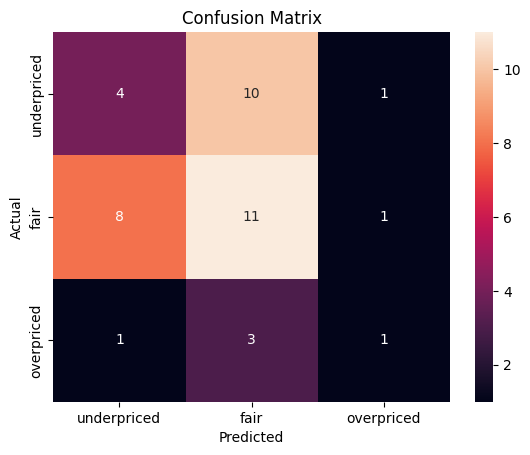

In [58]:
#Step 5: Evaluate the classifier 
y_pred = clf.predict(X_test)

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:\n")
conf_matrix = confusion_matrix(y_test, y_pred, labels=["underpriced", "fair", "overpriced"])
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=["underpriced", "fair", "overpriced"], yticklabels=["underpriced", "fair", "overpriced"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [26]:
#Step 6: Save the classifier model 
joblib.dump(clf, "classifier_model.pkl")
print("Classifier saved to notebooks/classifier_model.pkl")

Classifier saved to models/classifier_model.pkl
